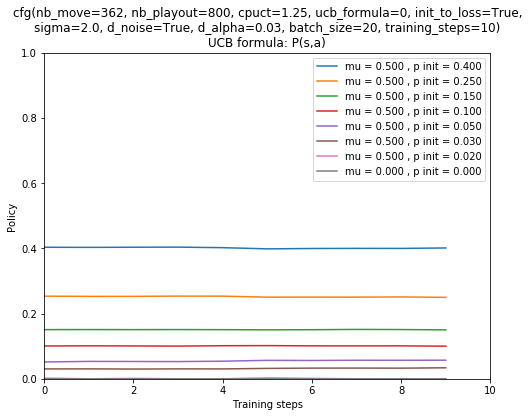

In [1]:
''' Exploring LZ MCTS policy improvement operator '''

''' Status: OK '''

from math import sqrt
import numpy as np
import textwrap as wrap
from copy import deepcopy

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)  # (w, h)

from collections import namedtuple

Net = namedtuple('net', ['policy', 'value'])   # A tuple modelling a network
PV = namedtuple('pv', ['policy', 'value'])     # A tuple modelling a bandit (or MC search).
                                               # The search prior is named 'policy', but can be either the net policy
                                               # or the mixture of net policy and dirichlet noise.

Cfg = namedtuple('cfg',['nb_move', 'nb_playout', 'cpuct', 'ucb_formula', 'init_to_loss', 'sigma', 'd_noise',\
                        'd_alpha', 'batch_size','training_steps'])
    

class MC_Root:
    ''' Implement MCTS on a root node '''
                
    def __init__(self, pv, cfg):
        self.pv = pv                           # Names tuple (Policy, Value)
        self.cfg = cfg                         # Names tuple config
        self.visits = 0                        # Total number of visits at root ( = playouts)                 
        self.N = np.zeros(cfg.nb_move,np.int_) # Vector of visit counts
        self.W = np.zeros(cfg.nb_move)         # Vector of accumulated action values
        self.U = np.zeros(cfg.nb_move)         # Vector of UCB terms
        self.A = np.zeros(cfg.nb_move)         # Vector of action selection term
        if self.cfg.init_to_loss: 
            self.Q = np.zeros(cfg.nb_move)     # Init to loss ( 0% win rate)
        else:
            self.Q = np.ones(cfg.nb_move)/2    # Init to Draw (50% win rate; here amount to init to Parent)

        
    def make_playout(self):
        ''' Does one playout and update selected child and root statistics '''
        
        for i in range(self.cfg.nb_move):
            if self.N[i] > 0: self.Q[i] = self.W[i] / self.N[i]
        
        if self.cfg.ucb_formula == 0:          # Current LZ formula (DM)
            P_polynom = self.pv.policy
        elif self.cfg.ucb_formula == 1:
            P_polynom = 0.99 * self.pv.policy + 0.01
        elif self.cfg.ucb_formula == 2:
            P_polynom = 0.90 * self.pv.policy + 0.10 * np.sqrt(self.pv.policy)
        elif self.cfg.ucb_formula == 3:
            P_polynom = 0.90 * self.pv.policy + 0.09 * np.sqrt(self.pv.policy) + 0.01
        else: print('Error: cfg.ucb_formula = ', self.cfg.ucb_formula)
        
        self.U = self.cfg.cpuct * P_polynom * sqrt(self.visits) / (1 + self.N)
        self.A = self.Q + self.U
        move = np.argmax(self.A)   
        self.W[move] += self.get_value(move)
        self.N[move] += 1
        self.visits  += 1
        

    def get_value(self, move):
        ''' Return net value estimate for move '''
        
        if self.cfg.sigma:
            return self.pv.value[move]                                     # Stationary values
        else:
            return np.random.normal(self.pv.value[move], self.cfg.sigma)   # Gaussian distributed values                                 # Stationary distribution of value

            
        
    def show(self):
        ''' Display root statistics. For debug. '''
        
        n = min(self.cfg.nb_move, 12)           # Assumes children of interest are the 12 first at most
        
        # Print headers:
        print('\n{:4d}/{:4d} playouts'.format(self.visits, self.cfg.nb_playout), \
              ' - Sigma:{:4.2f}'.format(self.cfg.sigma), end ='')
        print('\nMove:     ', end = '')
        for i in range(n):
            print('  {:4d}'.format(i), end = '')     
        print('\n          ', end = '')
        for i in range(n):
            print('  ----', end = '')      
        print('\nMu:       ', end = '')
        for i in range(n):
            print('  {:4.2f}'.format(self.pv.value[i]), end = '')      
        print('\nPolicy:   ', end = '')
        for i in range(n):
            print('  {:4.2f}'.format(self.pv.policy[i]), end = '')
        print('\n          ', end = '')
        for i in range(n):
            print('  ----', end = '') 

        # Print children stats:       
        print('\n  N(s,a): ', end = '')
        for i in range(n):
            print('  {:4d}'.format(self.N[i]), end = '')    
        print('\n  Visit%: ', end = '')
        for i in range(n):
            print('  {:4.2f}'.format(self.N[i] / self.visits), end = '')
#         print('\n  W(s,a): ', end = '')
#         for i in range(n):
#             print('  {:4.2f}'.format(self.W[i]), end = '')
        print('\n  Q(s,a): ', end = '')
        for i in range(n):
            print('  {:4.2f}'.format(self.Q[i]), end = '')
        print('\n  U(s,a): ', end = '')
        for i in range(n):
            print('  {:4.2f}'.format(self.U[i]), end = '')
        print('\n  A(s,a): ', end = '')
        for i in range(n):
            print('  {:4.2f}'.format(self.A[i]), end = '')
        print('\n')


class MC_Search:
    ''' Implement a MCTS from a root, guided by a net. Return visits distribution. '''
                
    def __init__(self, net, cfg):
                 
        self.net = deepcopy(net)
        self.cfg = cfg
        
        if self.cfg.d_noise:
            p = 0.75 * self.net.policy + 0.25 * np.random.dirichlet([self.cfg.d_alpha] * self.cfg.nb_move)
        else:
            p = self.net.policy
        
        pv = PV(p, self.net.value)
        self.root = MC_Root(pv, self.cfg)
        self.visit_pct = np.zeros(cfg.nb_move)
      
    def run(self):
                                                                                                           
        while self.root.visits < self.cfg.nb_playout:
            self.root.make_playout()
        self.visit_pct = self.root.N / self.root.visits

                                                                                                           
    def show(self):
        
        n = min(self.cfg.nb_move, 12)           # Assumes children of interest are the 12 first at most
        
        # Print headers:
        print('\n', self.cfg)
        print('\nMove:      ', end = '')
        for i in range(n):
            print('  {:6d}'.format(i), end = '')      
        print('\n           ', end = '')
        for i in range(n):
            print('  ------', end = '')    
        print('\nNet Mu:    ', end = '')
        for i in range(n):
            print('  {:6.4f}'.format(self.net.value[i]), end = '')      
        print('\nNet Pol:   ', end = '')
        for i in range(n):
            print('  {:6.4f}'.format(self.net.policy[i]), end = '')
        print('\nSearch Pol:', end = '')
        for i in range(n):
            print('  {:6.4f}'.format(self.root.pv.policy[i]), end = '')
            
        # Print visits stats:         
        print('\nVisit%:    ', end = '')
        for i in range(n):
            print('  {:6.4f}'.format(self.visit_pct[i]), end = '')                                                                               


class Training:
    ''' Implement the training of the policy of a network, based on batches of MC searches.'''
                
    def __init__(self, net, cfg):
                 
        self.net = deepcopy(net)
        self.cfg = cfg
    
    def net_update(self):
        ''' Execute 'batch_size' MC searches from root and calculate a policy target
            Update net policy by replacing it policy target (i.e. amounts to learning rate = 1) '''
        
        search_result = np.zeros((self.cfg.batch_size, self.cfg.nb_move))   # Empty array of policy targets vector 
        
        for search_nb in range(self.cfg.batch_size):            
            search = MC_Search(self.net, self.cfg)
            search.run()
            search_result[search_nb] = deepcopy(search.visit_pct)
            
        self.net.policy[:] = np.mean(search_result, axis = 0)[:]
          

    def net_show(self):
        ''' Display current net policy and value '''
        
        n = min(self.cfg.nb_move, 12)           # Assumes children of interest are the 12 first at most
        
        # Print headers:
        print('\nMove:      ', end = '')
        for i in range(n):
            print('  {:6d}'.format(i), end = '')      
        print('\n           ', end = '')
        for i in range(n):
            print('  ------', end = '')    
        print('\nNet Mu:    ', end = '')
        for i in range(n):
            print('  {:6.4f}'.format(self.net.value[i]), end = '')      
        print('\nNet Pol:   ', end = '')
        for i in range(n):
            print('  {:6.4f}'.format(self.net.policy[i]), end = '')
        print('\n')

    
        
if __name__ == "__main__":

    # Config
    # ------
    
    nb_move        = 362       # Number of legal moves
    nb_playout     = 800       # Numbetr of playout per search
    cpuct          = 1.25      # Expolration constant
    ucb_formula    = 0         # See formula label here below. 0 = Deepmind's formula for UCB term
    init_to_loss   = True      # True = Init Q to 0 / False = Init 50% win rate, here ~to init to Parent
    sigma          = 2.00      # Sigma use to randomize value head returns (gaussian distribution of value)
    d_noise        = True      # True = dirichlet noise enabled
    d_alpha        = 0.03      # Dirichlet noise concentration parameter ( 0.03 = DM value for Go)
    batch_size     = 20        # Number of MCTS searches used to calculate a policy training target
    training_steps = 10        # Number of training steps to execute

    cfg = Cfg(nb_move, nb_playout, cpuct, ucb_formula, init_to_loss, sigma, d_noise, d_alpha, batch_size, training_steps)
    
    formula_label = ['P(s,a)', '0.99*P(s,a) + 0.01', '0.90*P(s,a) + 0.10*P(s,a)^0.5',\
                     '0.90*P(s,a) + 0.09*P(s,a)^0.5 + 0.01']


    # Sample networks for 12 legal moves
    # ----------------------------------
    # Move:                0      1     2       3      4      5      6 
    
#     policy = np.array([0.200, 0.400, 0.270, 0.070, 0.030, 0.020, 0.010] + [0.000] * (nb_move - 7))
#     value  = np.array([0.500, 0.450, 0.490, 0.480, 0.400, 0.200, 0.510] + [0.000] * (nb_move - 7))
    
    # Move:                0      1     2       3      4      5      6
    policy = np.array([0.400, 0.250, 0.150, 0.100, 0.050, 0.030, 0.020, 0.00] + [0.000] * (nb_move - 8))
    value  = np.array([0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.00] + [0.000] * (nb_move - 8))
    
    
    
    # Sample network for 362 legal moves
    # ----------------------------------

#     # Move:                0      1     2       3      4      5      6
#     policy = np.array([0.200, 0.400, 0.270, 0.070, 0.030, 0.020, 0.010] + [0.000] * (nb_move - 7))
#     value  = np.array([0.500, 0.499, 0.490, 0.480, 0.400, 0.200, 0.510] + [0.000] * (nb_move - 7))

#     # Scenario: Equal win rates:
#     policy = np.array([0.240] * 4 + [0.010] * 4 + [0.000] * (nb_move - 8))   # Ex.: 4-4 totals 96% policy and 3-3 totals 4%
#     value  = np.array([0.500] * 4 + [0.520] * 4 + [0.000] * (nb_move - 8))   # Ex.: 4-4 and 3-3 have same 50% wr

#     # Scenario: Low policy move has higher win rate:
#     policy = np.array([0.240] * 4 + [0.010] * 4 + [0.000] * (nb_move - 8))   # Ex.: 4-4 totals 96% policy and 3-3 totals 4%
#     value  = np.array([0.500] * 4 + [0.510] * 4 + [0.000] * (nb_move - 8))   # Ex.: 4-4 has 50% wr while 3-3 has 51% wr

    net = Net(policy, value)


    # Main
    # ----
    
    training = Training(net, cfg)
#     training.net_show()
    
    policy_hist = np.empty((cfg.training_steps, 8))
    
    for step in range(cfg.training_steps):
        training.net_update()
#         print('Training step: ', step + 1 )
#         training.net_show()
        policy_hist[step] = training.net.policy[:8]

    # Graph:
    # ------
    title = wrap.fill(str(cfg), 80) + '\nUCB formula: {0}'.format(formula_label[cfg.ucb_formula])
    legend = ['mu = {:5.3f} , p init = {:5.3f}'.format(net.value[i], net.policy[i]) for i in range(cfg.nb_move)]

    graph = plt.plot(policy_hist)
    plt.title(title)
    plt.legend(graph[:cfg.nb_move], legend, loc='upper right', ncol = 1)
    plt.xlabel('Training steps')
    plt.ylabel('Policy')
    plt.axis([0, cfg.training_steps, -0.00, 1.0])
    plt.show()

